<a href="https://colab.research.google.com/github/Sandeep-4469/ML_Project/blob/main/The_Matrix_OG_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir -p /kaggle/working/datasets
!wget -O /kaggle/working/datasets/datasets.zip 'https://www.dropbox.com/scl/fo/pi9enz9ebq88u11bslzde/AEgFjW1vFsTtarLZVyFCV94?rlkey=fz9t33e4wzumesicz7o3t3680&st=16un1fgu&dl=1'
!unzip /kaggle/working/datasets/datasets.zip -d /kaggle/working/datasets
!rm /kaggle/working/datasets/datasets.zip
!wget -O data.csv https://www.dropbox.com/scl/fi/o7233oyy5ztnrq3kmolrj/DOM_hourly.csv?rlkey=8ax4e5ojld8ir5ivq9m8h9ag1&st=25jsg22t&dl=1

--2024-11-19 09:01:14--  https://www.dropbox.com/scl/fo/pi9enz9ebq88u11bslzde/AEgFjW1vFsTtarLZVyFCV94?rlkey=fz9t33e4wzumesicz7o3t3680&st=16un1fgu&dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc32457c402d1e3e69c76792266a.dl.dropboxusercontent.com/zip_download_get/CCHsPGdEBUyUhd-nwGfmd8I19kZHc-_ymkZ2byrSR7E4UczrQbM7K2RXcSQQdIxdWBaRnnncgeRXUHuA4IGvxV_8Gtk5CgogUPBvvbVhF0c1wA# [following]
--2024-11-19 09:01:15--  https://uc32457c402d1e3e69c76792266a.dl.dropboxusercontent.com/zip_download_get/CCHsPGdEBUyUhd-nwGfmd8I19kZHc-_ymkZ2byrSR7E4UczrQbM7K2RXcSQQdIxdWBaRnnncgeRXUHuA4IGvxV_8Gtk5CgogUPBvvbVhF0c1wA
Resolving uc32457c402d1e3e69c76792266a.dl.dropboxusercontent.com (uc32457c402d1e3e69c76792266a.dl.dropboxusercontent.com)... 162.125.1.15, 2620:100:6016:15::a27d:10f
Connecting to uc32457c402d1e3e69c76

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller

from pandas.plotting import autocorrelation_plot
from pandas.tseries.offsets import DateOffset

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import SimpleRNN, LSTM, Dense, Dropout
from keras import models, layers
import tensorflow as tf

import xgboost as xgb

import os

import seaborn as sns

In [ ]:
folder_path = '/kaggle/working/datasets'
files = os.listdir(folder_path)
files.sort()
files

['Yearly Demand Profile_17_24.xlsx',
 'Yearly Demand Profile_19-18.xlsx',
 'Yearly Demand Profile_21-20.xlsx',
 'Yearly Demand Profile_22-23.xlsx']

In [ ]:
dataframes = []
for file in files:
    file_path = os.path.join(folder_path, file)
    df = pd.read_excel(file_path)
    dataframes.append(df)

merged_df = pd.concat(dataframes, ignore_index=True)

merged_df.head()

,Year,Date,Hourly Demand Met (in MW)
0,2017,01-Jan 12am,108985.17
1,2017,01-Jan 1am,105856.08
2,2017,01-Jan 2am,103115.75
3,2017,01-Jan 3am,102407.04
4,2017,01-Jan 4am,104235.34


In [ ]:
data = merged_df.copy()

#EDA

##Null values

In [ ]:
data.isnull().sum()

Year                          4
Date                         16
Hourly Demand Met (in MW)    16
dtype: int64

In [ ]:
data.dropna(inplace=True)

In [ ]:
data.shape

(64248, 3)

In [ ]:
data

,Year,Date,Hourly Demand Met (in MW)
0,2017,01-Jan 12am,108985.17
1,2017,01-Jan 1am,105856.08
2,2017,01-Jan 2am,103115.75
3,2017,01-Jan 3am,102407.04
4,2017,01-Jan 4am,104235.34
...,...,...,...
64255,2022,31-Dec 7pm,175551.59
64256,2022,31-Dec 8pm,165990.79
64257,2022,31-Dec 9pm,157032.51
64258,2022,31-Dec 10pm,149875.96


#Data Preprocessing

In [ ]:
data['Datetime'] = pd.to_datetime(data['Year'].astype(str) + ' ' + data['Date'], format='%Y %d-%b %I%p')

data['day_of_year'] = data['Datetime'].dt.dayofyear
data['day_of_month'] = data['Datetime'].dt.day
data['day_of_week'] = data['Datetime'].dt.dayofweek  # 0 = Monday, 6 = Sunday
data['hour'] = data['Datetime'].dt.hour
data['month'] = data['Datetime'].dt.month
data['year'] = data['Datetime'].dt.year

data = data[['Datetime','day_of_year', 'day_of_month', 'day_of_week', 'hour', 'month', 'year', 'Hourly Demand Met (in MW)']]
data.rename(columns={'Hourly Demand Met (in MW)': 'energy'}, inplace=True)
data

/tmp/ipykernel_30/1947130210.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.rename(columns={'Hourly Demand Met (in MW)': 'energy'}, inplace=True)


,Datetime,day_of_year,day_of_month,day_of_week,hour,month,year,energy
0,2017-01-01 00:00:00,1,1,6,0,1,2017,108985.17
1,2017-01-01 01:00:00,1,1,6,1,1,2017,105856.08
2,2017-01-01 02:00:00,1,1,6,2,1,2017,103115.75
3,2017-01-01 03:00:00,1,1,6,3,1,2017,102407.04
4,2017-01-01 04:00:00,1,1,6,4,1,2017,104235.34
...,...,...,...,...,...,...,...,...
64255,2022-12-31 19:00:00,365,31,5,19,12,2022,175551.59
64256,2022-12-31 20:00:00,365,31,5,20,12,2022,165990.79
64257,2022-12-31 21:00:00,365,31,5,21,12,2022,157032.51
64258,2022-12-31 22:00:00,365,31,5,22,12,2022,149875.96


In [ ]:
data_sorted = data.sort_values(by='Datetime')
sorted_check = data_sorted['Datetime'].is_monotonic_increasing

if sorted_check:
    print("The Datetime column is now sorted in ascending order.")
else:
    print("The Datetime column is still not sorted.")

The Datetime column is now sorted in ascending order.


#Data Visualisation (-----)

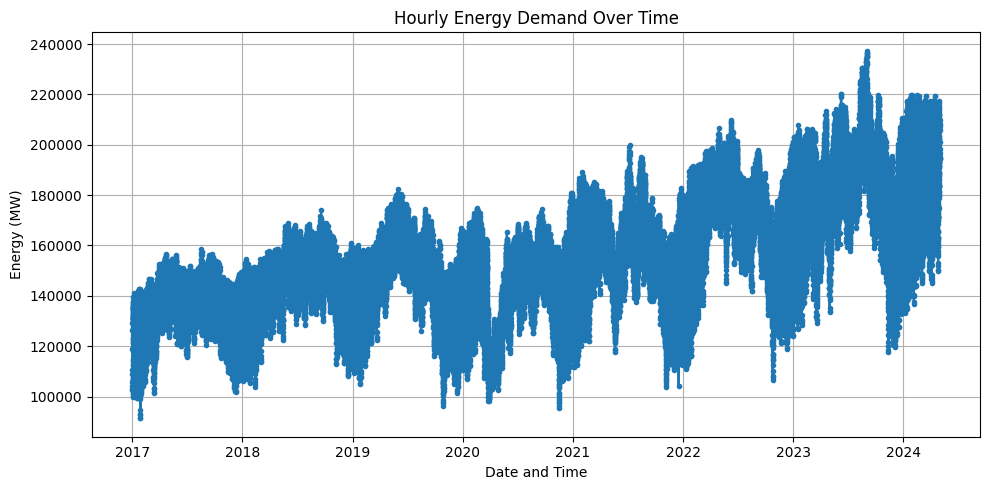

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(data_sorted['Datetime'], data_sorted['energy'],marker='.')
plt.title('Hourly Energy Demand Over Time')
plt.xlabel('Date and Time')
plt.ylabel('Energy (MW)')
plt.grid()
plt.tight_layout()
plt.show()

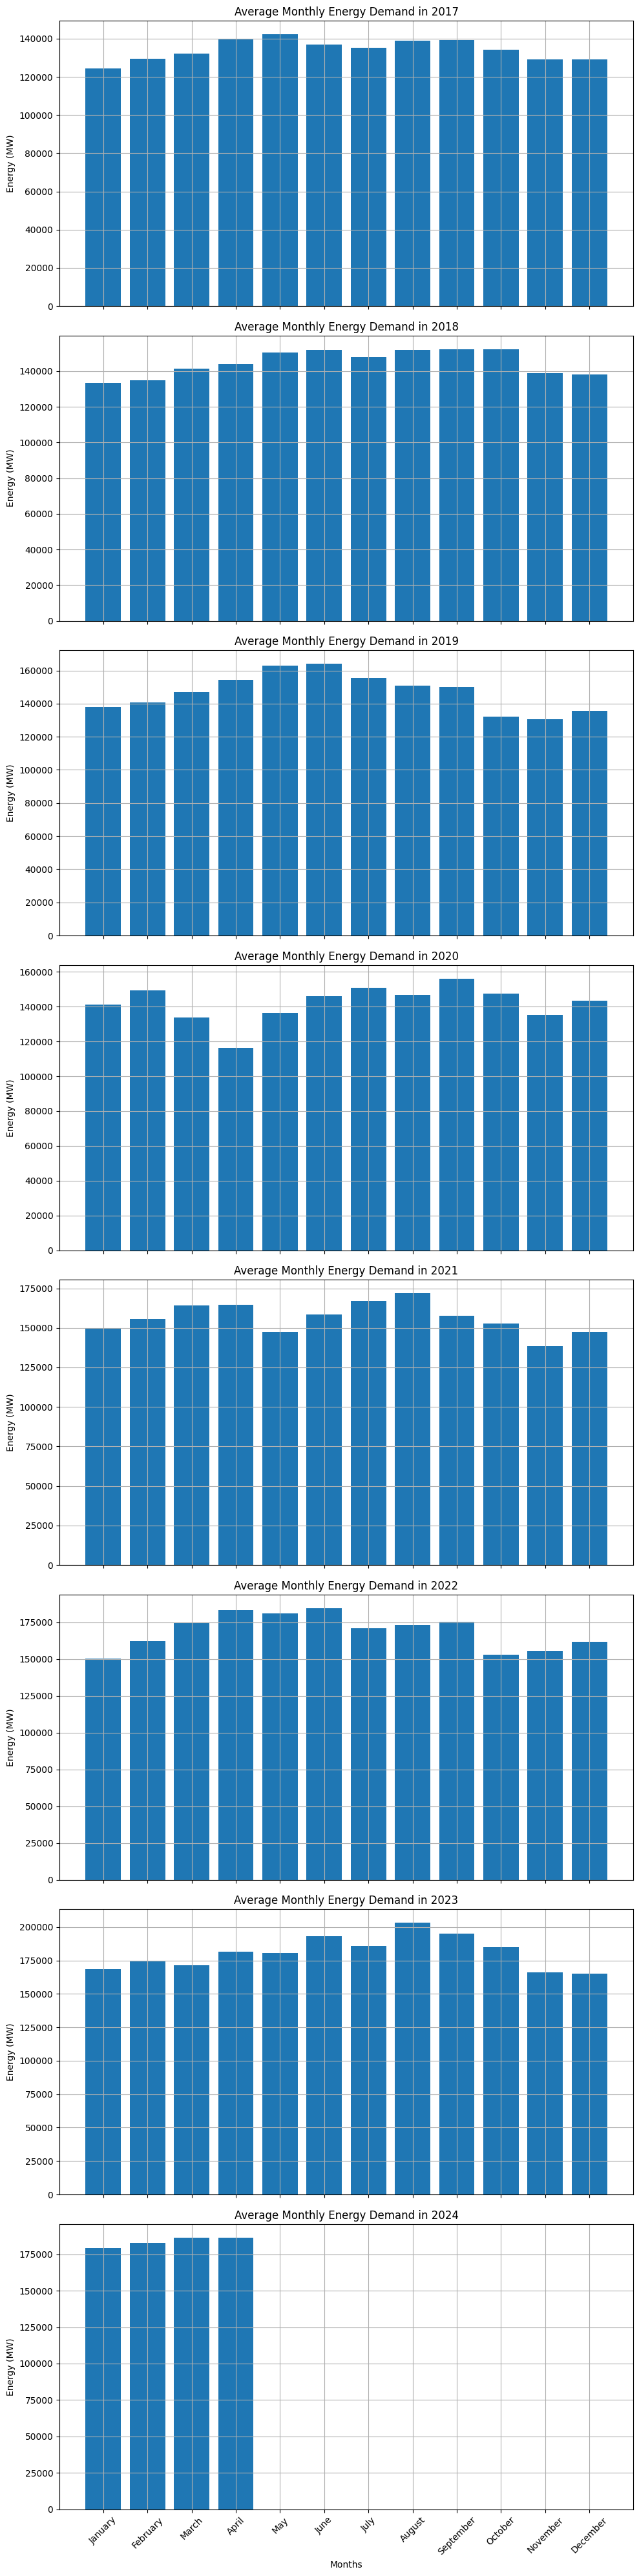

In [ ]:
unique_years = list(data['year'].unique())
unique_years.sort()
num_years = len(unique_years)

fig, axes = plt.subplots(num_years, 1, figsize=(10, 5 * num_years), sharex=True)

for ax, year in zip(axes, unique_years):
    year_data = data[data['year'] == year].copy()
    year_data.loc[:, 'Month'] = year_data['Datetime'].dt.month_name()

    monthly_data = year_data.groupby('Month')['energy'].mean().reindex(['January', 'February', 'March', 'April', 'May',
                                                                         'June', 'July', 'August', 'September',
                                                                         'October', 'November', 'December'])

    ax.bar(monthly_data.index, monthly_data.values)
    ax.set_title(f'Average Monthly Energy Demand in {year}')
    ax.set_ylabel('Energy (MW)')
    ax.grid()

plt.xlabel('Months')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

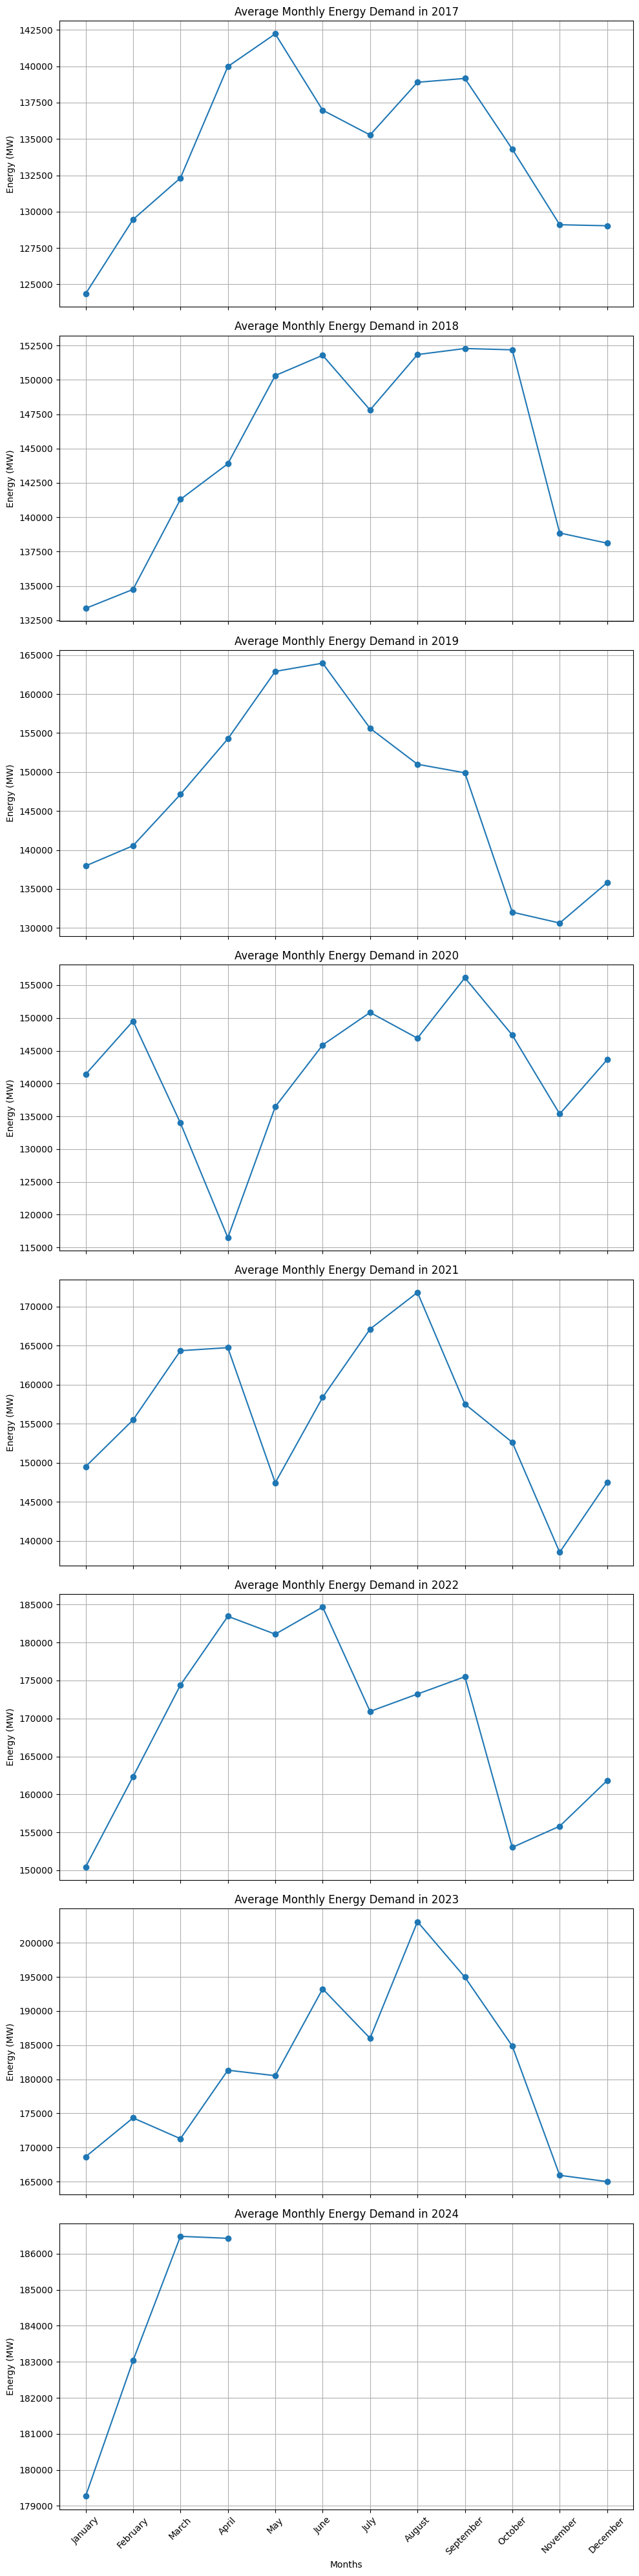

In [ ]:
fig, axes = plt.subplots(num_years, 1, figsize=(10, 5 * num_years), sharex=True)

for ax, year in zip(axes, unique_years):
    year_data = data[data['year'] == year].copy()
    year_data.loc[:, 'Month'] = year_data['Datetime'].dt.month_name()

    monthly_data = year_data.groupby('Month')['energy'].mean().reindex(['January', 'February', 'March', 'April', 'May',
                                                                         'June', 'July', 'August', 'September',
                                                                         'October', 'November', 'December'])

    ax.plot(monthly_data.index, monthly_data.values, marker='o')
    ax.set_title(f'Average Monthly Energy Demand in {year}')
    ax.set_ylabel('Energy (MW)')
    ax.grid()

plt.xlabel('Months')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

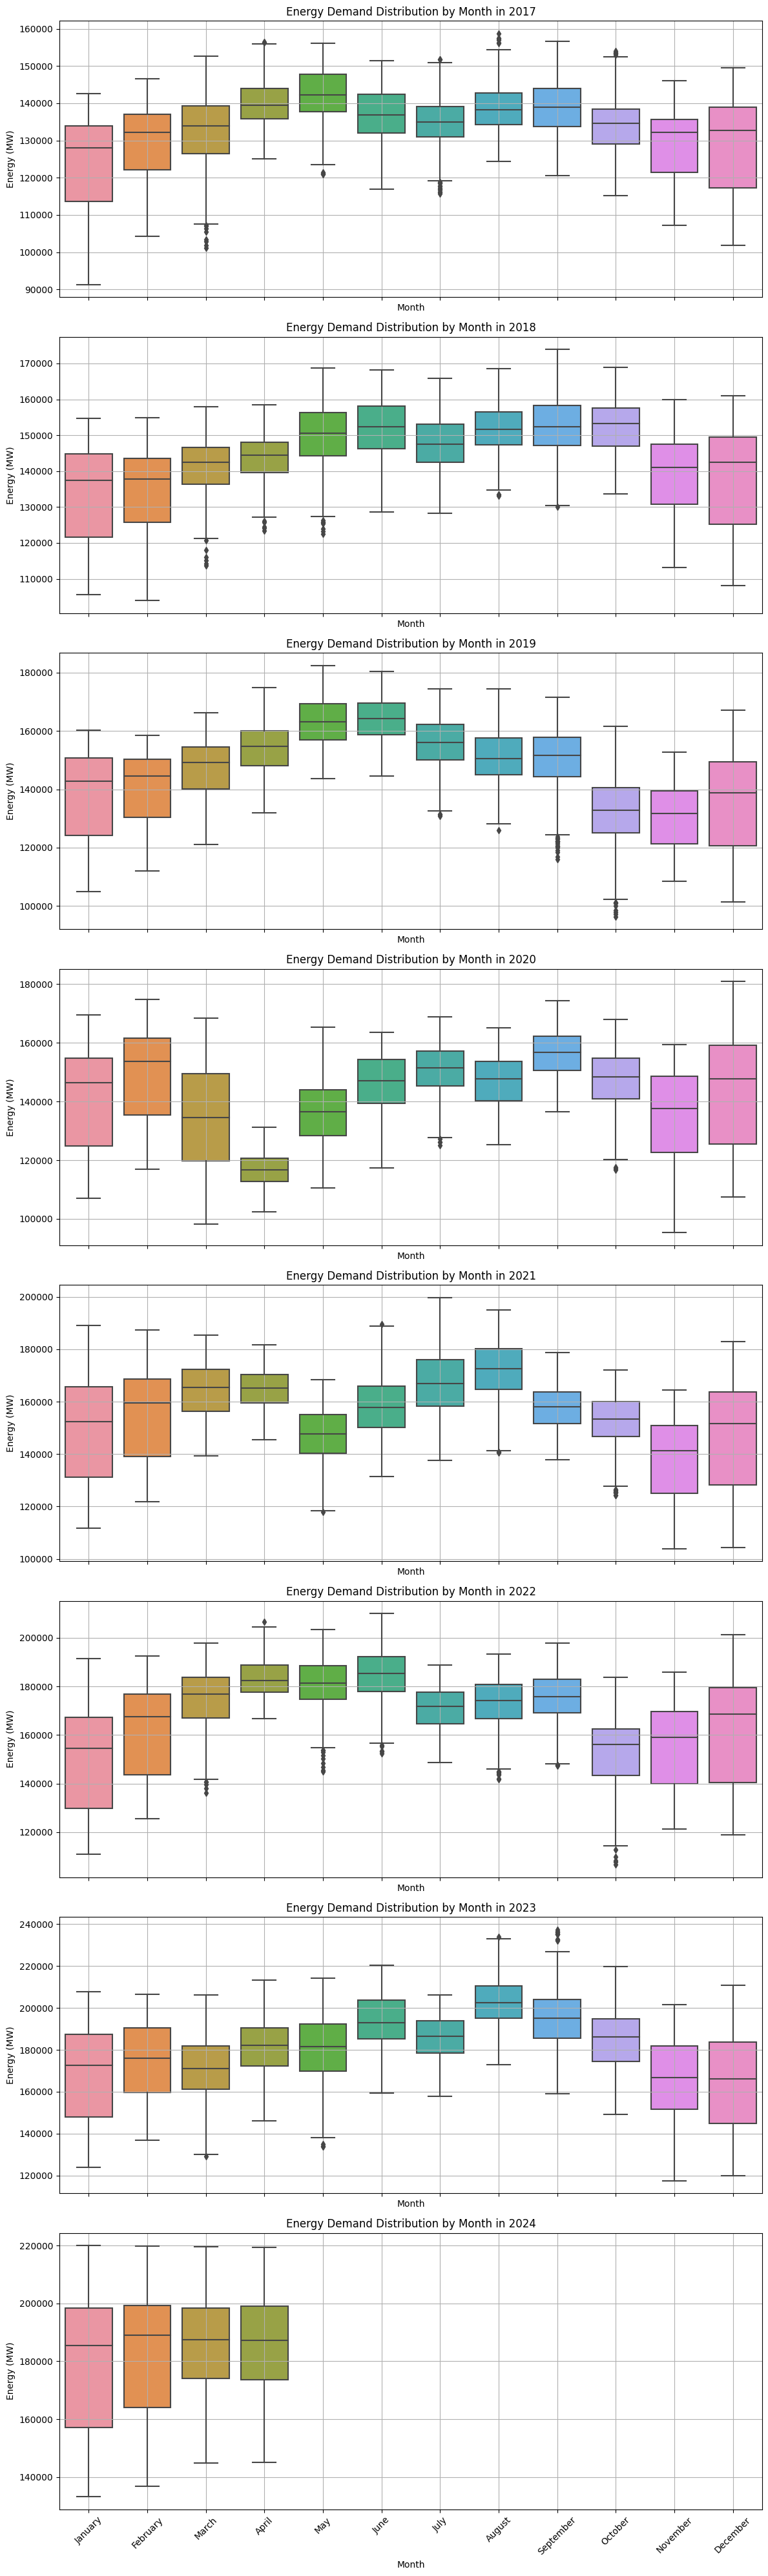

In [ ]:
fig, axes = plt.subplots(num_years, 1, figsize=(12, 5 * num_years), sharex=True)

for ax, year in zip(axes, unique_years):
    year_data = data[data['year'] == year].copy()
    year_data.loc[:, 'Month'] = year_data['Datetime'].dt.month_name()

    sns.boxplot(x='Month', y='energy', data=year_data, order=['January', 'February', 'March', 'April', 'May',
                                                               'June', 'July', 'August', 'September',
                                                               'October', 'November', 'December'], ax=ax)
    ax.set_title(f'Energy Demand Distribution by Month in {year}')
    ax.set_ylabel('Energy (MW)')
    ax.grid()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

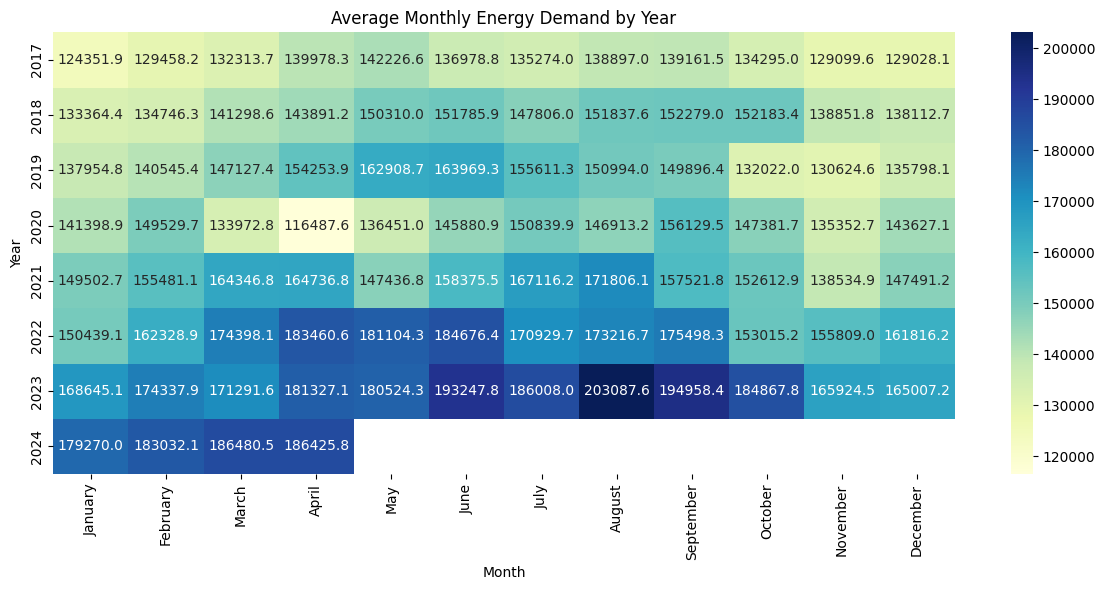

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

heatmap_data = data.copy()
heatmap_data['Month'] = heatmap_data['Datetime'].dt.month_name()

heatmap_summary = heatmap_data.groupby(['year', 'Month'])['energy'].mean().unstack().reindex(
    index=sorted(data['year'].unique()),
    columns=['January', 'February', 'March', 'April', 'May',
             'June', 'July', 'August', 'September',
             'October', 'November', 'December']
)

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_summary, annot=True, fmt=".1f", cmap='YlGnBu')
plt.title('Average Monthly Energy Demand by Year')
plt.xlabel('Month')
plt.ylabel('Year')
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

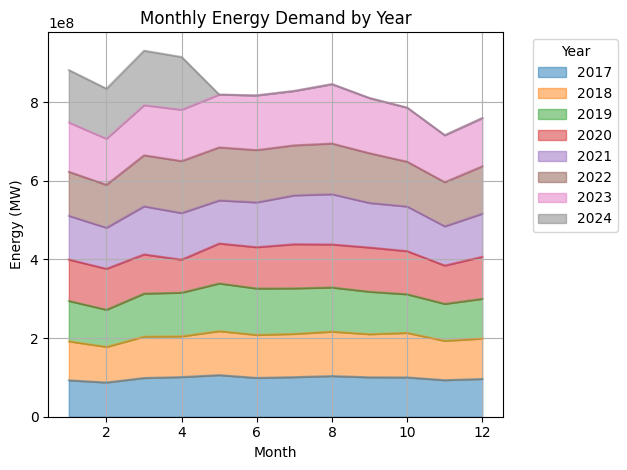

In [ ]:
monthly_data = data.groupby(['year', 'month'])['energy'].sum().unstack()

plt.figure(figsize=(12, 6))
monthly_data.T.plot(kind='area', alpha=0.5)
plt.title('Monthly Energy Demand by Year')
plt.xlabel('Month')
plt.ylabel('Energy (MW)')
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.tight_layout()
plt.show()

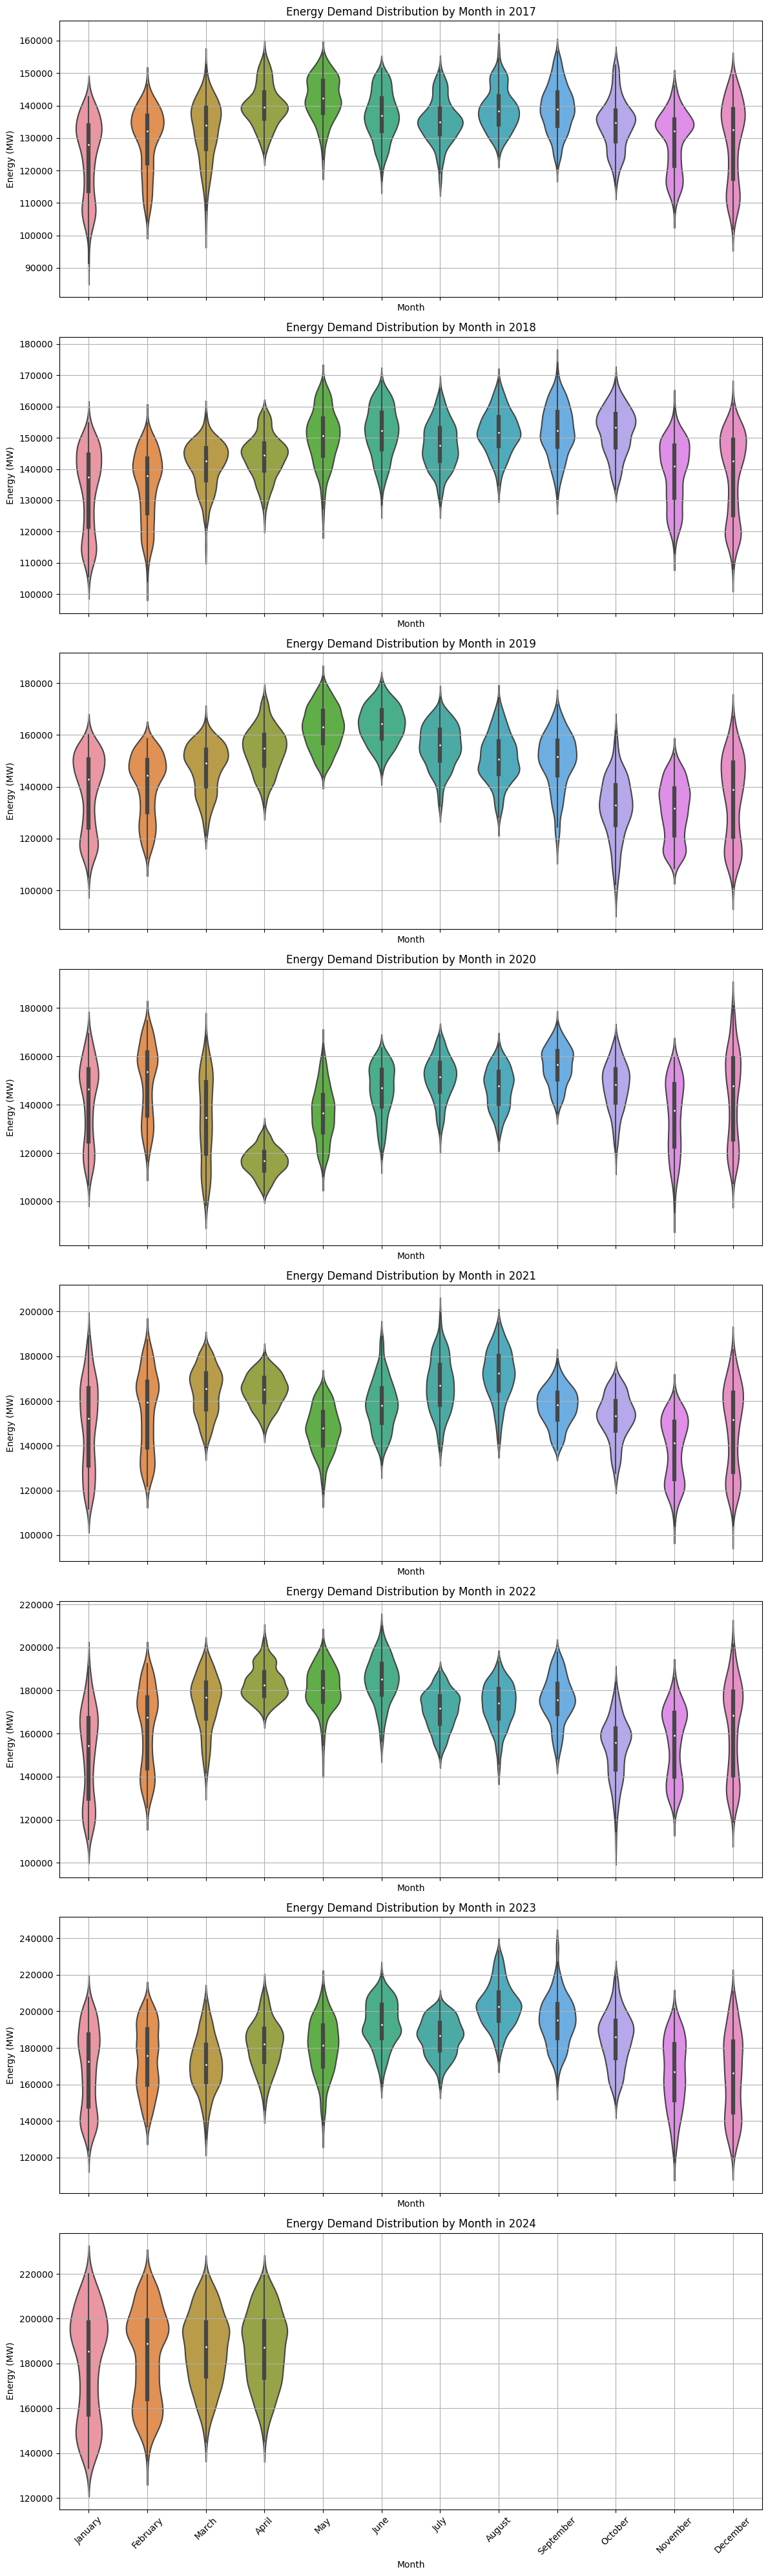

In [ ]:
fig, axes = plt.subplots(num_years, 1, figsize=(12, 5 * num_years), sharex=True)

for ax, year in zip(axes, unique_years):
    year_data = data[data['year'] == year].copy()
    year_data.loc[:, 'Month'] = year_data['Datetime'].dt.month_name()

    sns.violinplot(x='Month', y='energy', data=year_data,
                   order=['January', 'February', 'March', 'April', 'May',
                          'June', 'July', 'August', 'September',
                          'October', 'November', 'December'], ax=ax)

    ax.set_title(f'Energy Demand Distribution by Month in {year}')
    ax.set_ylabel('Energy (MW)')
    ax.grid()

plt.xlabel('Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Insights for Each Graph

## 1. Bar Graph: Average Monthly Energy Demand (2017-2024)

- **2017-2019**:
  - Relatively stable energy demand across months.
  - Slight peaks observed during summer months (June-August).
- **2020**:
  - Lower demand in early months, possibly due to the pandemic.
  - Recovery in the second half of the year.
- **2021-2023**:
  - Higher average demand compared to earlier years.
  - Significant peaks during summer months (June-August).


## 2. Box Plot: Energy Demand Distribution by Month (2017-2024)

- **2017-2019**:
  - Moderate variation in energy demand.
  - Fewer outliers and more consistent distribution.
- **2020**:
  - Large variation in demand, especially in early months due to the pandemic.
- **2021-2023**:
  - Increased variability, particularly in summer months.
  - Higher number of outliers suggests unusual demand patterns.
- **2023**:
  - Outliers suggest significant spikes in energy demand during summer (July-August).

## 3. Heatmap: Average Monthly Energy Demand by Year (2017-2024)

- **Color gradient**:
  - Lighter colors in earlier years (2017-2019) indicate lower demand.
  - Darker colors in 2021-2024 reflect rising energy consumption.
- **Seasonal patterns**:
  - Summer months (June-August) show peaks in demand across all years.
- **2023-2024**:
  - These years show significantly higher energy usage, especially in early 2024.

## 4. Violin Plot

1. **2017**:
   - Stable distribution throughout the year.
   - Slight peaks in May and July.

2. **2018**:
   - Noticeable increase in demand from April to August.
   - Higher variability in summer months.

3. **2019**:
   - Higher demand in April, May, and July.
   - Lower demand in November and December.

4. **2020**:
   - Sharp drop in April (possibly due to COVID-19).
   - Demand recovers by year-end.

5. **2021**:
   - Consistent increase from January to June.
   - Drop in August, recovery in December.

6. **2022**:
   - Fluctuations, especially in April and May.
   - Higher variance in the latter months.

7. **2023**:
   - High energy demand in July and August.
   - Stable but high variance across the year.

8. **2024**:
   - General increase in demand compared to earlier years.
   - July and August show the highest peaks.


#Stationary Test

In [ ]:
def adfuller_test(energy):
    result=adfuller(energy)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("Data has no unit root and is stationary")
        return 0
    else:
        print("Time series has a unit root, indicating it is non-stationary ")
        return 1
p = adfuller_test(data['energy'])

ADF Test Statistic : -5.406958682108428
p-value : 3.2750573334240568e-06
#Lags Used : 61
Number of Observations Used : 64186
Data has no unit root and is stationary


In [ ]:
def is_stationary(series):
    adf_result = adfuller(series)
    return adf_result[1] <= 0.05

def make_stationary(series):
    differenced_data = series.copy()
    num_differences = 0

    while not is_stationary(differenced_data):
        differenced_data = differenced_data.diff().dropna()
        num_differences += 1
        print(f"Applied differencing: {num_differences}")

    return differenced_data

In [ ]:
if p==1:
  df_stat = make_stationary(data['DOM_MW'])

else:
  df_stat = data.copy()

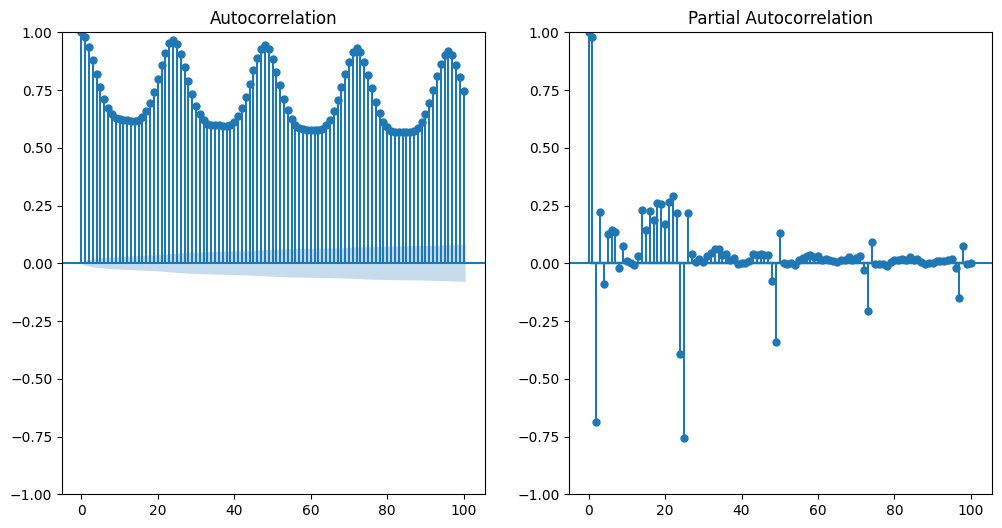

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sm.graphics.tsa.plot_acf(data['energy'], lags=100, ax=ax[0])
sm.graphics.tsa.plot_pacf(data['energy'], lags=100, ax=ax[1])
plt.show()

#Data Proprocessing

##MinMax Scaling

In [ ]:
target_scaler = MinMaxScaler()
target = data['energy'].values
target_scaled = target_scaler.fit_transform(target.reshape(-1,1))

##XGBOOST

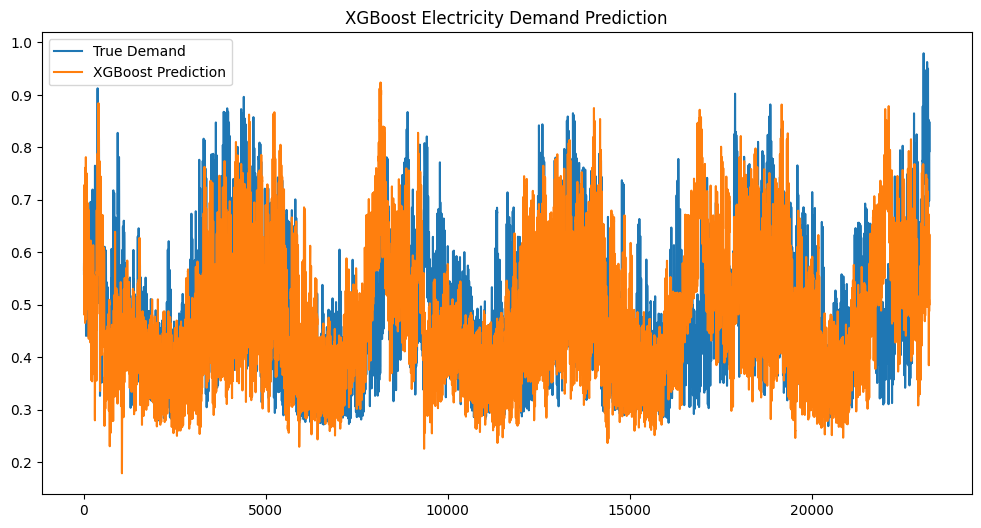

In [ ]:
xgb_model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.3, max_depth=6, reg_lambda=1)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

plt.figure(figsize=(12, 6))
plt.plot(y_test, label='True Demand')
plt.plot(xgb_pred, label='XGBoost Prediction')
plt.title('XGBoost Electricity Demand Prediction')
plt.legend()
plt.show()

##Making Sequential Data

In [ ]:
def create_sequences(X, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i + time_steps])
        ys.append(X[i + time_steps])
    return np.array(Xs), np.array(ys)

In [ ]:
TIME_STEPS = 20
X_seq, y_seq = create_sequences(target_scaled, TIME_STEPS)

In [ ]:
split_index = int(len(X_seq) * 0.8)
X_train_seq, X_test_seq = X_seq[:split_index], X_seq[split_index:]
y_train_seq, y_test_seq = y_seq[:split_index], y_seq[split_index:]

In [ ]:
target_scaler.inverse_transform(y_train_seq)

array([[119759.15],
       [115039.62],
       [110945.09],
       ...,
       [200358.91],
       [196235.85],
       [190313.25]])

#Models

##Basic Transformer

In [ ]:
# Transformer Model Definition
def transformer_forecasting_model(input_seq_len, num_features, embed_dim, num_heads, ff_dim, num_layers):
    inputs = layers.Input(shape=(input_seq_len, num_features))
    x = layers.Dense(embed_dim)(inputs)
    x = layers.Add()([x, positional_encoding(input_seq_len, embed_dim)])

    for _ in range(num_layers):
        x = encoder_layer(x, num_heads, ff_dim)

    decoder_input = layers.Input(shape=(1, num_features))
    y = layers.Dense(embed_dim)(decoder_input)
    y = layers.Add()([y, positional_encoding(1, embed_dim)])

    for _ in range(num_layers):
        y = decoder_layer(y, x, num_heads, ff_dim)

    outputs = layers.Dense(1)(y)
    return tf.keras.Model([inputs, decoder_input], outputs)

def encoder_layer(x, num_heads, ff_dim):
    attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=x.shape[-1])(x, x)
    x = layers.Add()([x, attn_output])
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    ff_output = layers.Dense(ff_dim, activation="relu")(x)
    ff_output = layers.Dense(x.shape[-1])(ff_output)
    x = layers.Add()([x, ff_output])
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x

def decoder_layer(y, enc_output, num_heads, ff_dim):
    attn1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=y.shape[-1])(y, y)
    y = layers.Add()([y, attn1])
    y = layers.LayerNormalization(epsilon=1e-6)(y)
    attn2 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=y.shape[-1])(y, enc_output)
    y = layers.Add()([y, attn2])
    y = layers.LayerNormalization(epsilon=1e-6)(y)
    ff_output = layers.Dense(ff_dim, activation="relu")(y)
    ff_output = layers.Dense(y.shape[-1])(ff_output)
    y = layers.Add()([y, ff_output])
    y = layers.LayerNormalization(epsilon=1e-6)(y)
    return y

def positional_encoding(seq_len, embed_dim):
    positions = tf.range(seq_len, dtype=tf.float32)[:, tf.newaxis]
    dimensions = tf.range(embed_dim, dtype=tf.float32)[tf.newaxis, :]
    angles = positions / tf.pow(10000, (2 * (dimensions // 2)) / embed_dim)
    pos_encoding = tf.where(dimensions % 2 == 0, tf.sin(angles), tf.cos(angles))
    return pos_encoding[tf.newaxis, ...]

input_seq_len = TIME_STEPS
num_features = 1
embed_dim = 64
num_heads = 4
ff_dim = 128
num_layers = 2

model = transformer_forecasting_model(input_seq_len, num_features, embed_dim, num_heads, ff_dim, num_layers)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

X_train_seq_ = X_train_seq[..., np.newaxis]
X_test_seq_ = X_test_seq[..., np.newaxis]
y_train_seq_ = y_train_seq[..., np.newaxis]
y_test_seq_ = y_test_seq[..., np.newaxis]

decoder_input_train = np.zeros((X_train_seq_.shape[0], 1, 1))
decoder_input_test = np.zeros((X_test_seq_.shape[0], 1, 1))

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

history = model.fit(
    [X_train_seq_, decoder_input_train], y_train_seq,
    validation_data=([X_test_seq_, decoder_input_test], y_test_seq_),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
I0000 00:00:1732006954.756202     120 service.cc:145] XLA service 0x7f1fc4002150 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732006954.756272     120 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  29/1606 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 4.5997 - mae: 1.3649  

I0000 00:00:1732006960.943629     120 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1606/1606 ━━━━━━━━━━━━━━━━━━━━ 35s 11ms/step - loss: 0.2230 - mae: 0.1335 - val_loss: 7.6109e-04 - val_mae: 0.0228
Epoch 2/50
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 5.4977e-04 - mae: 0.0179 - val_loss: 0.0014 - val_mae: 0.0323
Epoch 3/50
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 6.8851e-04 - mae: 0.0206 - val_loss: 4.9084e-04 - val_mae: 0.0178
Epoch 4/50
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 7.0504e-04 - mae: 0.0208 - val_loss: 8.1549e-04 - val_mae: 0.0228
Epoch 5/50
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 6.5811e-04 - mae: 0.0201 - val_loss: 3.5523e-04 - val_mae: 0.0146
Epoch 6/50
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 5.6858e-04 - mae: 0.0186 - val_loss: 6.0969e-04 - val_mae: 0.0198
Epoch 7/50
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 4.8843e-04 - mae: 0.0170 - val_loss: 0.0013 - val_mae: 0.0297
Epoch 8/50
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 4.1914e-04 - mae: 0.0159 - val_loss: 6.0113e-04 - val_mae: 0.0

In [ ]:
from sklearn.metrics import r2_score
test_loss, test_mae = model.evaluate([X_test_seq_, decoder_input_test], y_test_seq_)

# Predictions and R² Score
y_pred = model.predict([X_test_seq_, decoder_input_test]).flatten()
r2 = r2_score(y_test_seq_.flatten(), y_pred)
print("Test Loss:", test_loss)
print("Test MAE:", test_mae)
print("R² Score on Test Data:", r2)

402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.0977e-04 - mae: 0.0102


/opt/conda/lib/python3.10/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


402/402 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
Test Loss: 0.0001834150607464835
Test MAE: 0.00954396091401577
R² Score on Test Data: 0.9908107478005729


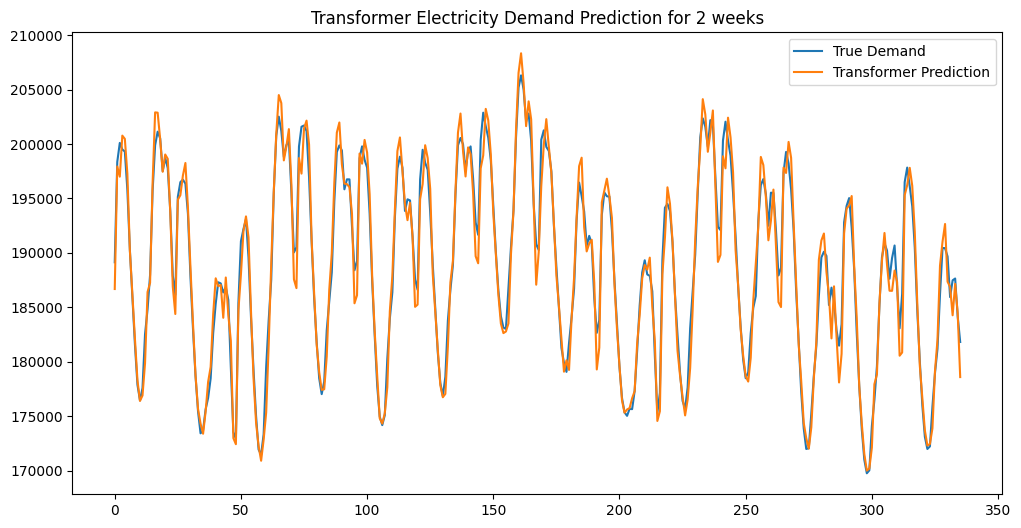

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(target_scaler.inverse_transform(y_test_seq)[:24*14], label='True Demand')
plt.plot(target_scaler.inverse_transform(y_pred.reshape(-1,1))[:24*14], label='Transformer Prediction')
plt.title('Transformer Electricity Demand Prediction for 2 weeks')
plt.legend()
plt.show()

##Transformer-2

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, MultiHeadAttention, Dropout, LayerNormalization, LSTM, Flatten
from tensorflow.keras.callbacks import EarlyStopping

tf.random.set_seed(42)

def transformer_encoder(inputs, num_heads, dff, dropout_rate):
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1])(inputs, inputs)
    attn_output = Dropout(dropout_rate)(attn_output)
    out1 = LayerNormalization(epsilon=1e-6)(inputs + attn_output)

    ffn = Dense(dff, activation='relu')(out1)
    ffn = Dense(inputs.shape[-1])(ffn)
    ffn_output = Dropout(dropout_rate)(ffn)
    out2 = LayerNormalization(epsilon=1e-6)(out1 + ffn_output)

    return out2

def transformer_decoder(inputs, encoder_output, num_heads, dff, dropout_rate):
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1])(inputs, encoder_output)
    attn_output = Dropout(dropout_rate)(attn_output)
    out1 = LayerNormalization(epsilon=1e-6)(inputs + attn_output)

    ffn = Dense(dff, activation='relu')(out1)
    ffn = Dense(inputs.shape[-1])(ffn)
    ffn_output = Dropout(dropout_rate)(ffn)
    out2 = LayerNormalization(epsilon=1e-6)(out1 + ffn_output)

    return out2

def build_lstm_transformer_model(input_shape, lstm_units, num_heads, dff, num_layers, dropout_rate):
    inputs = Input(shape=input_shape)
    lstm_output = LSTM(lstm_units, return_sequences=True)(inputs)

    encoder_output = lstm_output
    for _ in range(num_layers):
        encoder_output = transformer_encoder(encoder_output, num_heads, dff, dropout_rate)

    decoder_input = encoder_output
    for _ in range(num_layers):
        decoder_input = transformer_decoder(decoder_input, encoder_output, num_heads, dff, dropout_rate)

    x = Flatten()(decoder_input)
    x = Dense(50, activation='relu')(x)
    x = Dense(1)(x)
    return Model(inputs, x)

lstm_units = 64
num_heads = 4
dff = 128
num_layers = 2
dropout_rate = 0.1

input_shape = (TIME_STEPS, X_train_seq.shape[-1])
lstm_transformer_model = build_lstm_transformer_model(input_shape, lstm_units, num_heads, dff, num_layers, dropout_rate)
lstm_transformer_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = lstm_transformer_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping]
)

loss, mae = lstm_transformer_model.evaluate(X_test_seq, y_test_seq)
print(f"Test Loss: {loss:.4f}, Test MAE: {mae:.4f}")

Epoch 1/50
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 48s 22ms/step - loss: 0.0919 - mae: 0.1690 - val_loss: 0.0119 - val_mae: 0.1038
Epoch 2/50
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 35s 22ms/step - loss: 0.0026 - mae: 0.0400 - val_loss: 0.0061 - val_mae: 0.0716
Epoch 3/50
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 35s 22ms/step - loss: 0.0015 - mae: 0.0302 - val_loss: 0.0019 - val_mae: 0.0373
Epoch 4/50
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 35s 22ms/step - loss: 0.0011 - mae: 0.0260 - val_loss: 0.0015 - val_mae: 0.0331
Epoch 5/50
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 36s 22ms/step - loss: 8.7967e-04 - mae: 0.0230 - val_loss: 5.6466e-04 - val_mae: 0.0189
Epoch 6/50
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 35s 22ms/step - loss: 7.2043e-04 - mae: 0.0208 - val_loss: 8.1362e-04 - val_mae: 0.0239
Epoch 7/50
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 35s 22ms/step - loss: 5.8611e-04 - mae: 0.0186 - val_loss: 6.0070e-04 - val_mae: 0.0198
Epoch 8/50
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 36s 22ms/step - loss: 4.9824e-04 - mae: 0.0172 - val_loss: 5.0889e-04 - val_mae:

In [ ]:
loss, mae = lstm_transformer_model.evaluate(X_test_seq, y_test_seq)
print(f"Test Loss: {loss:.4f}, Test MAE: {mae:.4f}")
y_pred_t2 = lstm_transformer_model.predict(X_test_seq)
r2 = r2_score(y_test_seq.flatten(), y_pred_t2)
print(f"Test R² Score: {r2:.4f}")

402/402 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.4903e-04 - mae: 0.0090
Test Loss: 0.0002, Test MAE: 0.0090
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test R² Score: 0.9924


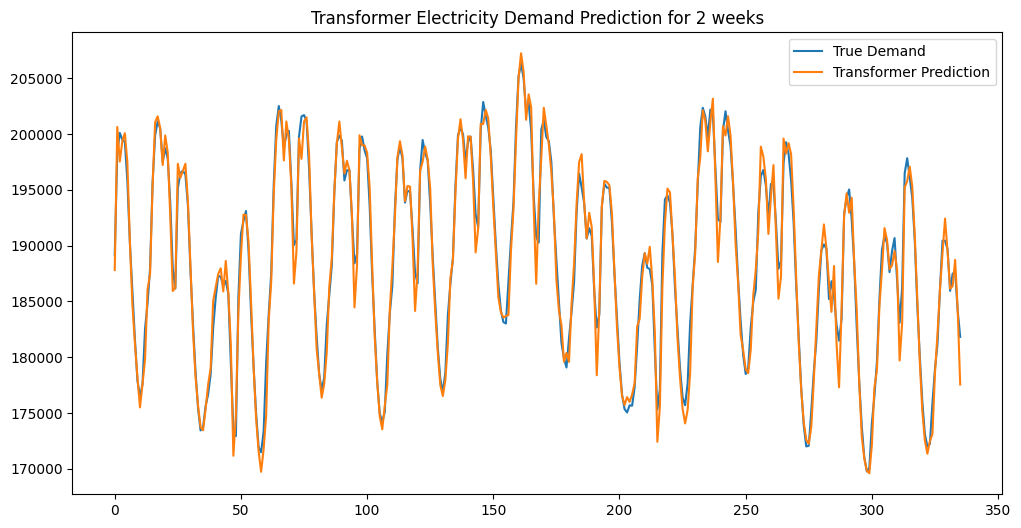

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(target_scaler.inverse_transform(y_test_seq)[:24*14], label='True Demand')
plt.plot(target_scaler.inverse_transform(y_pred_t2.reshape(-1,1))[:24*14], label='Transformer Prediction')
plt.title('Transformer Electricity Demand Prediction for 2 weeks')
plt.legend()
plt.show()

##RNN

In [ ]:
rnn_model = Sequential()
rnn_model.add(SimpleRNN(40, activation='tanh', return_sequences=True, input_shape=(TIME_STEPS, X_train_seq.shape[2])))
rnn_model.add(Dropout(0.2))
rnn_model.add(SimpleRNN(40, activation='tanh', return_sequences=True))
rnn_model.add(Dropout(0.2))
rnn_model.add(SimpleRNN(40, activation='tanh'))
rnn_model.add(Dropout(0.2))
rnn_model.add(Dense(1))

rnn_model.compile(optimizer='adam', loss='mean_squared_error')
rnn_model.fit(X_train_seq, y_train_seq, epochs=20, batch_size=32, verbose=1)
rnn_predictions = rnn_model.predict(X_test_seq)
y_pred_rnn_flat = rnn_predictions.flatten()

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1606/1606 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 0.0862
Epoch 2/20
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.0026
Epoch 3/20
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.0012
Epoch 4/20
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 8.5307e-04
Epoch 5/20
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 7.2469e-04
Epoch 6/20
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 6.8650e-04
Epoch 7/20
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 6.7103e-04
Epoch 8/20
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 6.3027e-04
Epoch 9/20
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 6.4084e-04
Epoch 10/20
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 6.3800e-04
Epoch 11/20
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 6.2243e-04
Epoch 12/20
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 6.2033e-04
Epoch 13/20
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 6.2034e-04
Epoch 14/20
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 6.2095

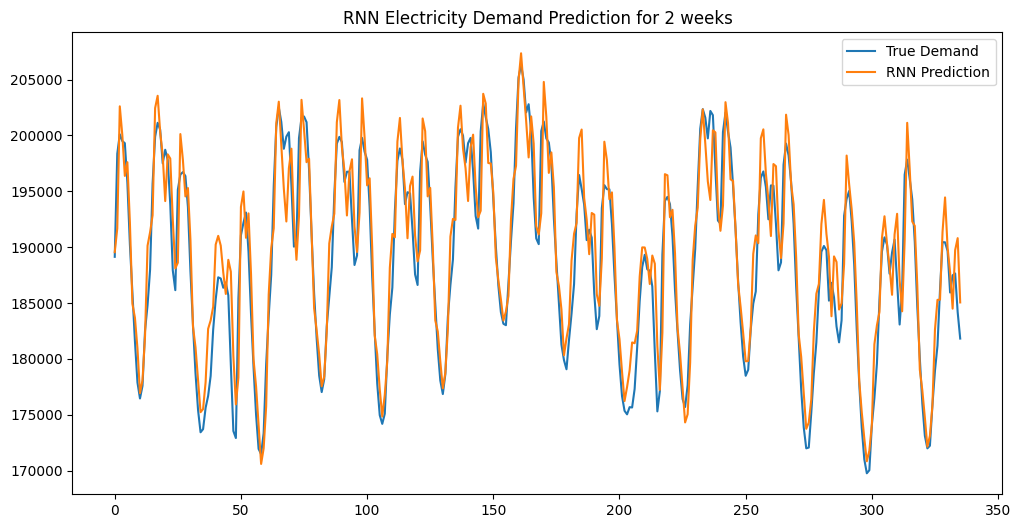

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(target_scaler.inverse_transform(y_test_seq)[:24*14], label='True Demand')
plt.plot(target_scaler.inverse_transform(y_pred_rnn_flat.reshape(-1,1))[:24*14], label='RNN Prediction')
plt.title('RNN Electricity Demand Prediction for 2 weeks')
plt.legend()
plt.show()

##LSTM (simple)

In [ ]:
lstm_model = Sequential()
lstm_model.add(LSTM(60, activation='tanh', return_sequences=True, input_shape=(X_train_seq.shape[1], 1)))
lstm_model.add(Dropout(0.15))
lstm_model.add(LSTM(40, activation='tanh', return_sequences=True))
lstm_model.add(Dropout(0.15))
lstm_model.add(LSTM(40, activation='tanh'))
lstm_model.add(Dropout(0.15))
lstm_model.add(Dense(1))

lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train_seq, y_train_seq, epochs=20, batch_size=32, verbose=1)
lstm_predictions = lstm_model.predict(X_test_seq)
y_pred_lstm_flat = lstm_predictions.flatten()

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1606/1606 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - loss: 0.0099
Epoch 2/20
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 0.0014
Epoch 3/20
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 8.0813e-04
Epoch 4/20
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 6.2802e-04
Epoch 5/20
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 5.6330e-04
Epoch 6/20
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 5.3531e-04
Epoch 7/20
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 5.0464e-04
Epoch 8/20
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 4.8315e-04
Epoch 9/20
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 4.6974e-04
Epoch 10/20
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 4.6445e-04
Epoch 11/20
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 4.4277e-04
Epoch 12/20
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - loss: 4.3655e-04
Epoch 13/20
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - loss: 4.2734e-04
Epoch 14/20
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/st

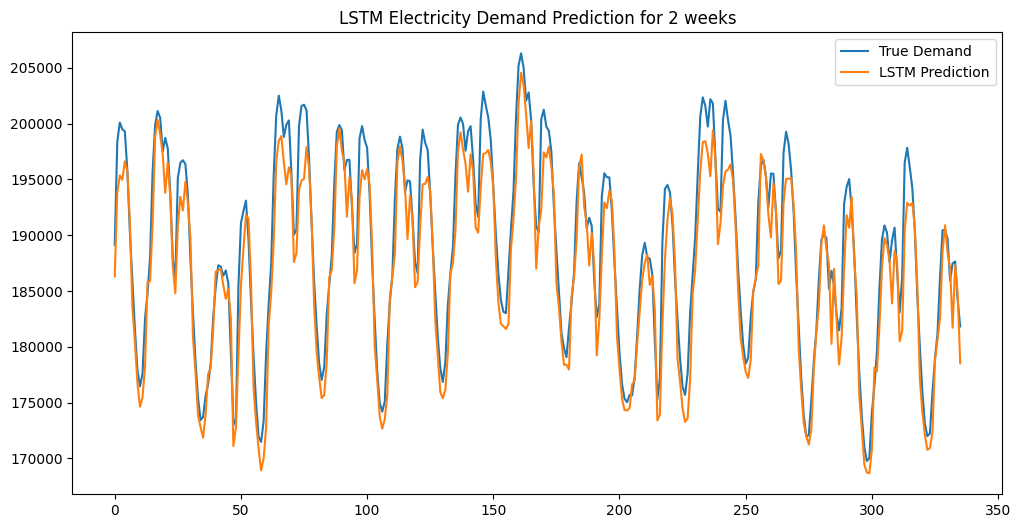

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(target_scaler.inverse_transform(y_test_seq)[:24*14], label='True Demand')
plt.plot(target_scaler.inverse_transform(y_pred_lstm_flat.reshape(-1,1))[:24*14], label='LSTM Prediction')
plt.title('LSTM Electricity Demand Prediction for 2 weeks')
plt.legend()
plt.show()

##Stacked LSTM

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

stacked_lstm_model = Sequential()
stacked_lstm_model.add(LSTM(60, activation='tanh', return_sequences=True, input_shape=(X_train_seq.shape[1], 1)))
stacked_lstm_model.add(Dropout(0.15))
stacked_lstm_model.add(LSTM(40, activation='tanh', return_sequences=True))
stacked_lstm_model.add(Dropout(0.15))
stacked_lstm_model.add(LSTM(40, activation='tanh'))  # Final LSTM layer without `return_sequences`
stacked_lstm_model.add(Dropout(0.15))
stacked_lstm_model.add(Dense(1))

stacked_lstm_model.compile(optimizer='adam', loss='mean_squared_error')

stacked_lstm_model.fit(X_train_seq, y_train_seq, epochs=20, batch_size=32, verbose=1)

stacked_lstm_predictions = stacked_lstm_model.predict(X_test_seq)
y_pred_stacked_lstm_flat = stacked_lstm_predictions.flatten()

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1606/1606 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - loss: 0.0099
Epoch 2/20
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 0.0013
Epoch 3/20
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 8.1175e-04
Epoch 4/20
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 6.2626e-04
Epoch 5/20
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 5.6116e-04
Epoch 6/20
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 5.3795e-04
Epoch 7/20
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 5.1466e-04
Epoch 8/20
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 4.9064e-04
Epoch 9/20
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 4.8405e-04
Epoch 10/20
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 4.7254e-04
Epoch 11/20
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 4.4563e-04
Epoch 12/20
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 4.3854e-04
Epoch 13/20
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 4.1725e-04
Epoch 14/20
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/st

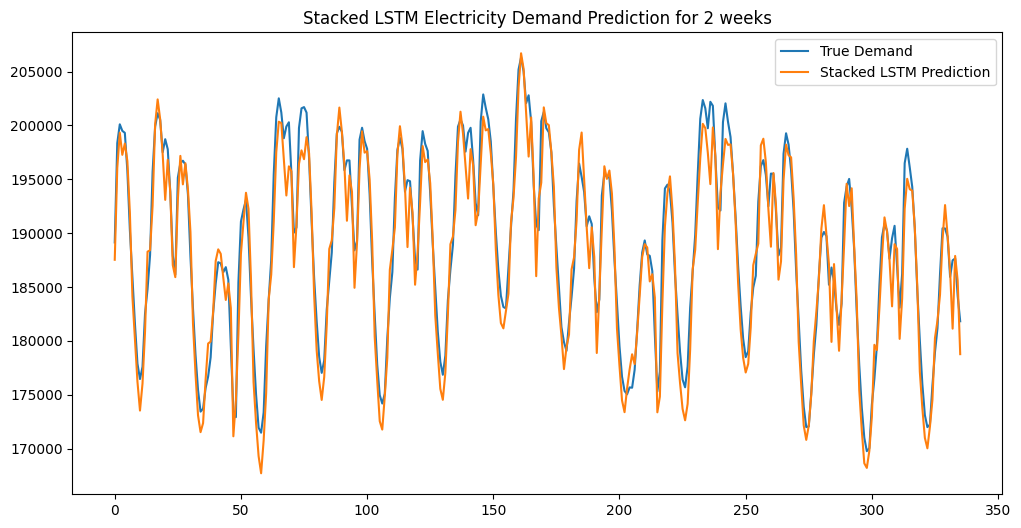

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(target_scaler.inverse_transform(y_test_seq)[:24*14], label='True Demand')
plt.plot(target_scaler.inverse_transform(y_pred_stacked_lstm_flat.reshape(-1,1))[:24*14], label='Stacked LSTM Prediction')
plt.title('Stacked LSTM Electricity Demand Prediction for 2 weeks')
plt.legend()
plt.show()

##Bidirectional LSTM

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional

bilstm_model = Sequential()
bilstm_model.add(Bidirectional(LSTM(60, activation='tanh', return_sequences=True), input_shape=(X_train_seq.shape[1], 1)))
bilstm_model.add(Dropout(0.15))
bilstm_model.add(Bidirectional(LSTM(40, activation='tanh', return_sequences=True)))
bilstm_model.add(Dropout(0.15))
bilstm_model.add(Bidirectional(LSTM(40, activation='tanh')))
bilstm_model.add(Dropout(0.15))
bilstm_model.add(Dense(1))

bilstm_model.compile(optimizer='adam', loss='mean_squared_error')

bilstm_model.fit(X_train_seq, y_train_seq, epochs=20, batch_size=32, verbose=1)

bilstm_predictions = bilstm_model.predict(X_test_seq)
y_pred_bilstm_flat = bilstm_predictions.flatten()

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1606/1606 ━━━━━━━━━━━━━━━━━━━━ 25s 13ms/step - loss: 0.0069
Epoch 2/20
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - loss: 0.0011
Epoch 3/20
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - loss: 8.3490e-04
Epoch 4/20
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - loss: 6.8316e-04
Epoch 5/20
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - loss: 5.7234e-04
Epoch 6/20
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - loss: 4.6233e-04
Epoch 7/20
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - loss: 4.1776e-04
Epoch 8/20
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - loss: 3.9955e-04
Epoch 9/20
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - loss: 3.7258e-04
Epoch 10/20
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - loss: 3.6595e-04
Epoch 11/20
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - loss: 3.6371e-04
Epoch 12/20
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - loss: 3.3986e-04
Epoch 13/20
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - loss: 3.3388e-04
Epoch 14/20
1606/1606 ━━━━━━━━━━━━━━━━━━

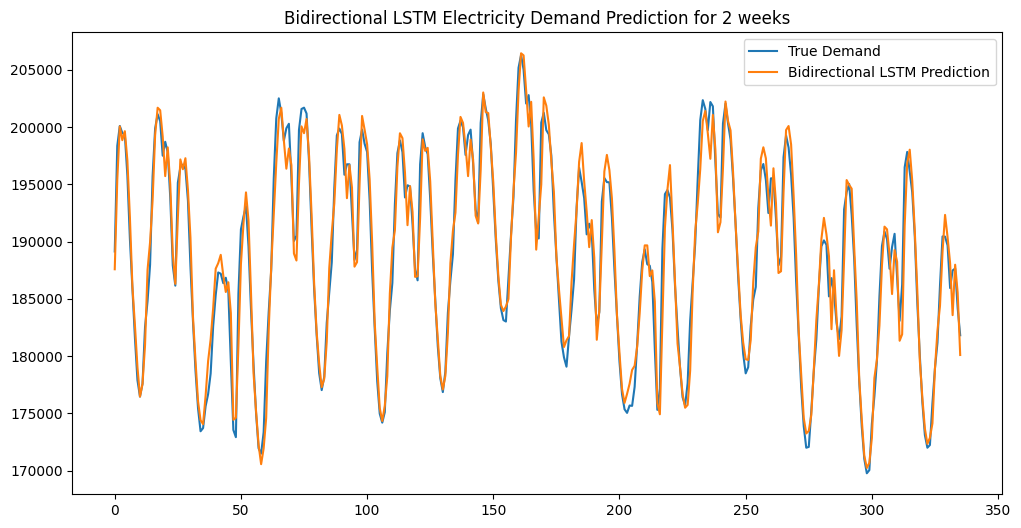

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(target_scaler.inverse_transform(y_test_seq)[:24*14], label='True Demand')
plt.plot(target_scaler.inverse_transform(y_pred_bilstm_flat.reshape(-1,1))[:24*14], label='Bidirectional LSTM Prediction')
plt.title('Bidirectional LSTM Electricity Demand Prediction for 2 weeks')
plt.legend()
plt.show()

##GRU

In [ ]:
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout

gru_model = Sequential()
gru_model.add(GRU(60, activation='tanh', return_sequences=True, input_shape=(X_train_seq.shape[1], 1)))
gru_model.add(Dropout(0.15))
gru_model.add(GRU(40, activation='tanh', return_sequences=True))
gru_model.add(Dropout(0.15))
gru_model.add(GRU(40, activation='tanh'))
gru_model.add(Dropout(0.15))
gru_model.add(Dense(1))

gru_model.compile(optimizer='adam', loss='mean_squared_error')

gru_model.fit(X_train_seq, y_train_seq, epochs=10, batch_size=32, verbose=1)

gru_predictions = gru_model.predict(X_test_seq)
y_pred_gru_flat = gru_predictions.flatten()

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1606/1606 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 0.0066
Epoch 2/10
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.0010
Epoch 3/10
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 7.7429e-04
Epoch 4/10
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 6.5563e-04
Epoch 5/10
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 6.1631e-04
Epoch 6/10
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 6.0691e-04
Epoch 7/10
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 4.9926e-04
Epoch 8/10
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 4.6486e-04
Epoch 9/10
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 4.6280e-04
Epoch 10/10
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 4.5591e-04
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


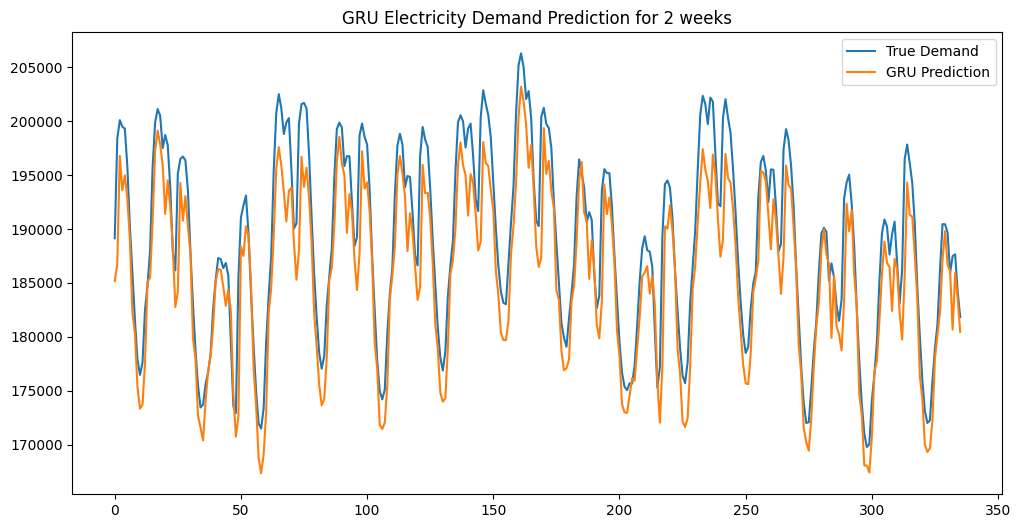

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(target_scaler.inverse_transform(y_test_seq)[:24*14], label='True Demand')
plt.plot(target_scaler.inverse_transform(y_pred_gru_flat.reshape(-1,1))[:24*14], label='GRU Prediction')
plt.title('GRU Electricity Demand Prediction for 2 weeks')
plt.legend()
plt.show()

##LSTM with attention

In [ ]:
from keras.models import Model
from keras.layers import LSTM, Dropout, Dense, Input, Attention, Concatenate, Reshape

input_shape = (X_train_seq.shape[1], 1)

inputs = Input(shape=input_shape)

lstm_out1 = LSTM(60, activation='tanh', return_sequences=True)(inputs)
dropout1 = Dropout(0.15)(lstm_out1)

lstm_out2 = LSTM(60, activation='tanh', return_sequences=True)(dropout1)
dropout2 = Dropout(0.15)(lstm_out2)

attention = Attention()([dropout1, dropout2])
merged = Concatenate()([dropout2, attention])

lstm_out3 = LSTM(40, activation='tanh')(merged)
dropout3 = Dropout(0.15)(lstm_out3)

output = Dense(1)(dropout3)

lstm_att = Model(inputs, output)

lstm_att.compile(optimizer='adam', loss='mean_squared_error')

lstm_att.fit(X_train_seq, y_train_seq, epochs=20, batch_size=32, verbose=1)

att_predictions = lstm_att.predict(X_test_seq)
y_pred_att_flat = lstm_predictions.flatten()

Epoch 1/20
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - loss: 0.0099
Epoch 2/20
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 0.0013
Epoch 3/20
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 7.7265e-04
Epoch 4/20
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 5.9630e-04
Epoch 5/20
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 5.4205e-04
Epoch 6/20
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 5.0469e-04
Epoch 7/20
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 4.8530e-04
Epoch 8/20
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 4.7336e-04
Epoch 9/20
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 4.4825e-04
Epoch 10/20
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 4.3281e-04
Epoch 11/20
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 4.3637e-04
Epoch 12/20
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 4.0637e-04
Epoch 13/20
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 4.0417e-04
Epoch 14/20
1606/1606 ━━━━━━━━━━━━━━━━━━━━

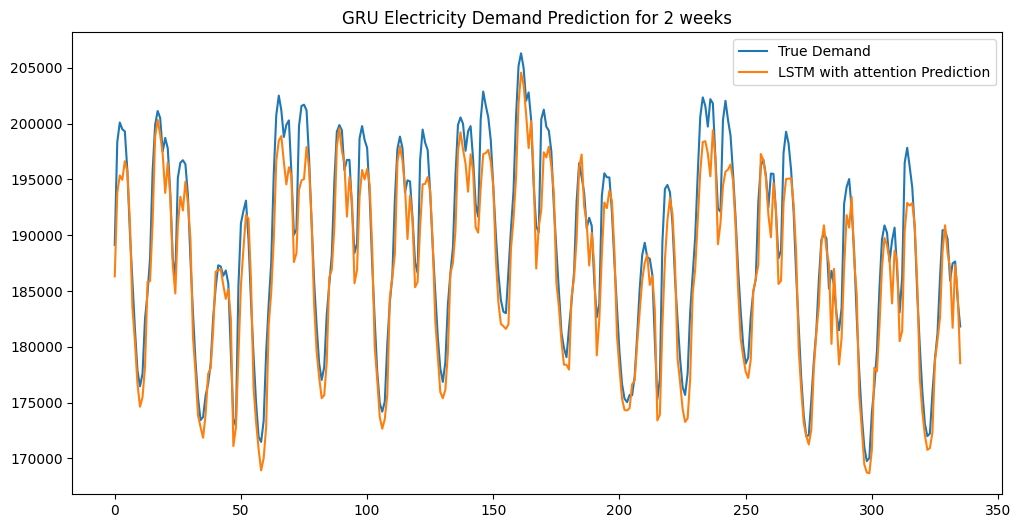

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(target_scaler.inverse_transform(y_test_seq)[:24*14], label='True Demand')
plt.plot(target_scaler.inverse_transform(y_pred_att_flat.reshape(-1,1))[:24*14], label='LSTM with attention Prediction')
plt.title('GRU Electricity Demand Prediction for 2 weeks')
plt.legend()
plt.show()

#Metrics

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd

y_pred_lstm_inv = target_scaler.inverse_transform(y_pred_lstm_flat.reshape(-1, 1)).flatten()
y_pred_rnn_inv = target_scaler.inverse_transform(y_pred_rnn_flat.reshape(-1, 1)).flatten()
y_pred_gru_inv = target_scaler.inverse_transform(y_pred_gru_flat.reshape(-1, 1)).flatten()
y_pred_bilstm_inv = target_scaler.inverse_transform(y_pred_bilstm_flat.reshape(-1, 1)).flatten()
y_pred_att_inv = target_scaler.inverse_transform(y_pred_att_flat.reshape(-1, 1)).flatten()
y_test_inv = target_scaler.inverse_transform(y_test_seq.reshape(-1, 1)).flatten()
y_pred_stacked_lstm_inv = target_scaler.inverse_transform(y_pred_stacked_lstm_flat.reshape(-1, 1)).flatten()
y_pred_t2_inv = target_scaler.inverse_transform(y_pred_t2.reshape(-1, 1)).flatten()
y_pred_inv = target_scaler.inverse_transform(y_pred.reshape(-1,1)).flatten()
metrics = {
    'Model': ['LSTM', 'RNN', 'GRU', 'Bidirectional LSTM', 'LSTM with Attention','Stacked LSTM', 'Basic Transformer', 'Trasformer with LSTM'],
    'Mean Absolute Error (MAE)': [
        mean_absolute_error(y_test_inv, y_pred_lstm_inv),
        mean_absolute_error(y_test_inv, y_pred_rnn_inv),
        mean_absolute_error(y_test_inv, y_pred_gru_inv),
        mean_absolute_error(y_test_inv, y_pred_bilstm_inv),
        mean_absolute_error(y_test_inv, y_pred_att_inv),
        mean_absolute_error(y_test_inv, y_pred_stacked_lstm_inv),
        mean_absolute_error(y_test_inv, y_pred_inv),
        mean_absolute_error(y_test_inv, y_pred_t2_inv)

    ],
    'Mean Squared Error (MSE)': [
        mean_squared_error(y_test_inv, y_pred_lstm_inv),
        mean_squared_error(y_test_inv, y_pred_rnn_inv),
        mean_squared_error(y_test_inv, y_pred_gru_inv),
        mean_squared_error(y_test_inv, y_pred_bilstm_inv),
        mean_squared_error(y_test_inv, y_pred_att_inv),
        mean_squared_error(y_test_inv, y_pred_stacked_lstm_inv),
        mean_squared_error(y_test_inv, y_pred_inv),
        mean_squared_error(y_test_inv, y_pred_t2_inv)
    ],
    'R-squared (R²)': [
        r2_score(y_test_inv, y_pred_lstm_inv),
        r2_score(y_test_inv, y_pred_rnn_inv),
        r2_score(y_test_inv, y_pred_gru_inv),
        r2_score(y_test_inv, y_pred_bilstm_inv),
        r2_score(y_test_inv, y_pred_att_inv),
        r2_score(y_test_inv, y_pred_stacked_lstm_inv),
        r2_score(y_test_inv, y_pred_inv),
        r2_score(y_test_inv, y_pred_t2_inv)

    ]
}

evaluation_metrics = pd.DataFrame(metrics)

evaluation_metrics

,Model,Mean Absolute Error (MAE),Mean Squared Error (MSE),R-squared (R²)
0,LSTM,2110.102726,7.420218e+06,0.982566
1,RNN,2503.218045,1.018274e+07,0.976076
2,GRU,2968.317922,1.402047e+07,0.967059
3,Bidirectional LSTM,1792.298263,5.759778e+06,0.986467
4,LSTM with Attention,2110.102726,7.420218e+06,0.982566
5,Stacked LSTM,2042.554057,6.915697e+06,0.983752
6,Basic Transformer,1393.686081,3.911177e+06,0.990811
7,Trasformer with LSTM,1310.485208,3.224733e+06,0.992424
